# Reversal learning task

Probability ratings will be used to derive both model-free and model-based parameters that will describe the quality of learning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

#import pymc3 as pm
#import arviz as az

#import theano
#import theano.tensor as tt

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    temp = pd.read_csv(sub)
    temp['sub']= sub.split("_")[2]
    temp['CSp'] = temp.rectOri[2]
    db = db.append(temp)

In [3]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans')
age = age.iloc[:,1:8:6]
age.rename(columns={age.columns[0]: "sub" }, inplace = True)
age['sub'] = age['sub'].map(lambda x: x.lstrip('AG_'))

age = age.dropna()
age = age.drop_duplicates('sub')
db = db.merge(age, left_on='sub', right_on='sub')


In [4]:
db['rating_clean'] = db.rating
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

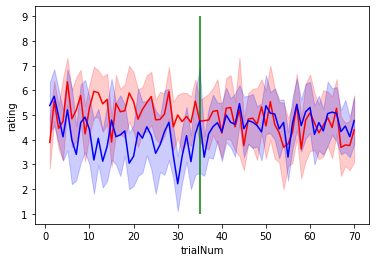

In [5]:
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri==db.CSp)], color ='red')
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri!=db.CSp)], color='blue')
plt.vlines(x=35, ymin=1, ymax=9, colors='green')

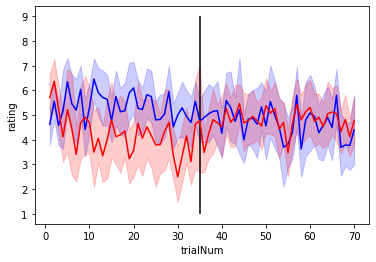

In [6]:
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

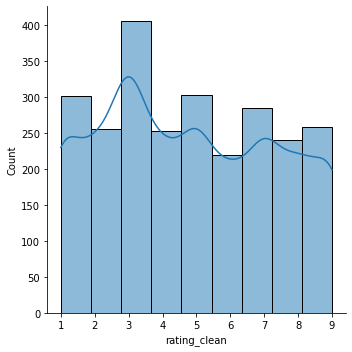

In [7]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late reversal and late acquisition


In [8]:
subs = db['sub'].unique()

model_free= pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSpA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSmA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    
    CSpeR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])
    CSmeR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])

    CSpR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSmR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSpA - CSmA
    dCSp = CSpA - CSpR 
    dCSm = CSmR - CSmA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ':[ACQ], 'dCSp':[dCSp], 'dCSm':[dCSm], 
                         'age':[df.Age[0]], 'CSpR':[CSpR], 'CSpeR': [CSpeR],
                        'CSmeR':[CSmeR], 'CSmR':[CSmR]})
    model_free = model_free.append(temp)

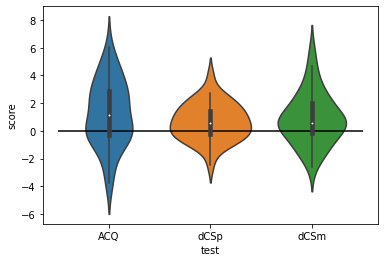

In [9]:
fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'dCSp', 'dCSm'], value_name='score', var_name = 'test')
sns.violinplot(x = 'test', y='score', data=fig2)
plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

<AxesSubplot:xlabel='age', ylabel='dCSm'>

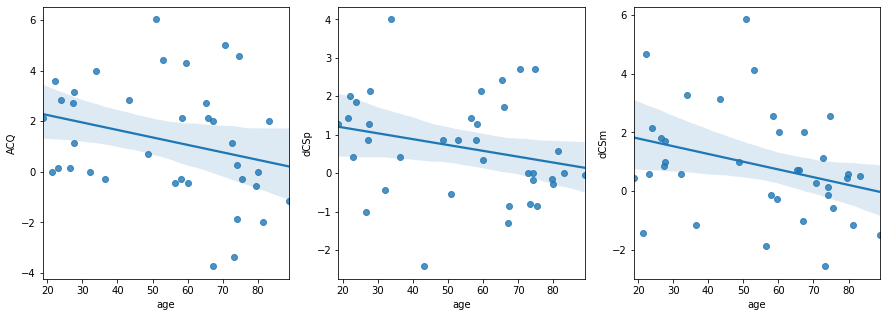

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(y = 'ACQ',  x = 'age', data=model_free, ax=axes[0])
sns.regplot(y = 'dCSp', x = 'age', data=model_free, ax=axes[1])
sns.regplot(y = 'dCSm', x = 'age', data=model_free, ax=axes[2])

<AxesSubplot:xlabel='CSmeR', ylabel='CSmR'>

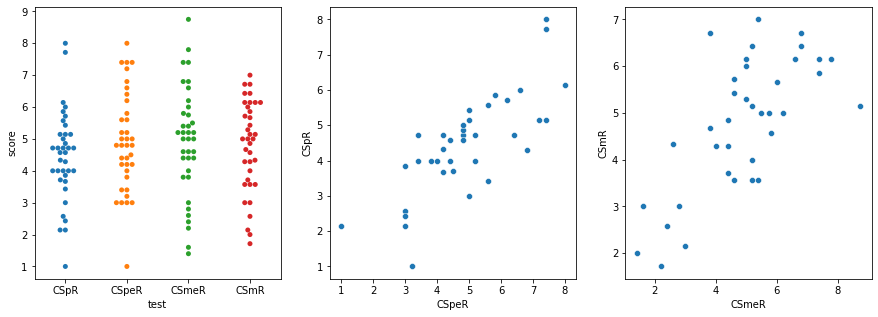

In [11]:
fig3 = pd.melt(model_free, id_vars='sub', value_vars=['CSpR', 'CSpeR', 'CSmeR', 'CSmR'], value_name='score', var_name = 'test')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ident = [0.0, 9.0]

sns.swarmplot(x = 'test', y = 'score', data = fig3, ax=axes[0])
sns.scatterplot(x = 'CSpeR', y = 'CSpR', data = model_free, ax = axes[1])
sns.scatterplot(x = 'CSmeR', y = 'CSmR', data = model_free, ax = axes[2])
#plt.plot(ident,ident)

## Rescorla-Wagner model 

#### Estimating the learning parameters via Maximum Likelihood

In [152]:
x=df[df['rectOri']==45]['rectValue']
x.to_list()

[0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 6, 0, 6, 6, 0]

In [139]:
import scipy as sp

In [141]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    stims, US = args
    
    # Initialize values
    Q = np.array([.5, .5])
    log_prob_stims = np.zeros(len(stims))
    
    for t, (a, r) in enumerate(zip(stims, US)):
    # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_stim = Q_ - sp.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_stims[t] = log_prob_stim[a]
        # Update the Q values for the next trial
        
        Q[a] = Q[a] + alpha * (r - Q[a])
        print("beta: {}, Q0= {:0.3f} Q[1]= {:0.3f}".format(beta, Q[0], Q[1]))

    
    # Return the negative log likelihood of all observed actions
    return (-np.sum(log_prob_stims[1:]))

In [142]:
def subject_data(sub_n):

    df = db[db['sub'] == sub_n].reset_index()
    ratingVec = df['rating_clean'].values
    rewVec = np.zeros(len(ratingVec), dtype=np.int32) # vector to capture Picture (1=yes, 0=no)
    stimVec = np.zeros(len(ratingVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 0= CS-)
    nTrials = len(df) # grab number of trials
    
    for i in range(nTrials):
        if df.rectValue[i] > 0:
            rewVec[i] = 1
        if df.rectOri[i] == df.CSp[i]:
            stimVec[i] = 1
    
    if ((ratingVec.shape == rewVec.shape) & (ratingVec.shape == stimVec.shape)):
        return (nTrials, ratingVec, rewVec, stimVec)
    else:
        print(error in sub)

In [143]:
nTrials, ratingVec, rewVec, stimVec = subject_data('13')

In [146]:
x0 = [0.5, 5]
result = sp.optimize.minimize(llik_td, x0, args=(stimVec, rewVec), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f}')
print(f'MLE: beta = {result.x[1]:.2f}')

      fun: 46.185642973605916
 hess_inv: array([[ 0.06508533, -0.68638219],
       [-0.68638219,  8.78990135]])
      jac: array([4.76837158e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 99
      nit: 18
     njev: 33
   status: 0
  success: True
        x: array([0.13506723, 2.21323572])

MLE: alpha = 0.14
MLE: beta = 2.21


In [62]:
import cmdstanpy
import arviz as az

In [92]:
db1 = db[db['trialNum'] < 36]
db1 = db1.reset_index()

In [76]:
db1.rectValue[i]

0

In [93]:
ratingVec = np.array(db1['rating'])
usVec     = np.zeros(len(ratingVec), dtype=np.int32)
stimVec   = np.ones(len(ratingVec), dtype=np.int32)

for i in range(len(db1)):
    if db1.rectValue[i] > 0:
        usVec[i] = 1
    if db1.rectOri[i] == db1.CSp[i]:
        stimVec[i] = 2
        
nTrials = len(db1[db1['sub']=='10'])
N       = len(subs)
Tsubj   = [nTrials]*N
stim    = np.reshape(stimVec,   (N, nTrials)).T
US      = np.reshape(usVec,     (N, nTrials)).T
ratings = np.reshape(ratingVec, (N, nTrials)).T


In [ ]:
nTrials = len(db[db['sub']=='10'])
N       = len(subs)
Tsubj   = [nTrials]*N
stim    = np.reshape(stimVec,   (N, nTrials)).T
US      = np.reshape(usVec,     (N, nTrials)).T
ratings = np.reshape(ratingVec, (N, nTrials)).T

In [94]:
data =  {'N': N, 'T': nTrials, 'Tsubj': Tsubj,
         'rating': ratings, 'lambda':US, 'stim': stim}
rw_bayes = cmdstanpy.CmdStanModel(stan_file='RW_model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/nachshon/Documents/Aging/Reversal/RW_model


In [95]:
# Train the model and generate samples
seed = 2019 # set random seed
fit_simple_model = rw_bayes.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [96]:
model = az.from_cmdstanpy(fit_simple_model)
az.summary(model, var_names=['A', 'mu_p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.100,0.072,0.000,0.207,0.002,0.001,2438.0,1690.0,1.00
A[1],0.051,0.044,0.000,0.116,0.002,0.001,1550.0,1156.0,1.00
A[2],0.208,0.108,0.022,0.412,0.002,0.001,2696.0,2638.0,1.00
A[3],0.259,0.228,0.000,0.647,0.006,0.004,1599.0,2732.0,1.00
A[4],0.020,0.053,0.000,0.061,0.003,0.002,731.0,316.0,1.01
A[5],0.235,0.175,0.000,0.544,0.003,0.002,3250.0,2533.0,1.00
A[6],0.097,0.068,0.000,0.205,0.002,0.001,1690.0,1173.0,1.00
A[7],0.058,0.060,0.000,0.154,0.002,0.002,1162.0,763.0,1.00
A[8],0.319,0.065,0.202,0.445,0.001,0.001,4891.0,3689.0,1.00
A[9],0.168,0.164,0.000,0.485,0.003,0.002,2237.0,2457.0,1.00


array([[<AxesSubplot:title={'center':'A\n0'}>,
        <AxesSubplot:title={'center':'A\n1'}>,
        <AxesSubplot:title={'center':'A\n2'}>,
        <AxesSubplot:title={'center':'A\n3'}>],
       [<AxesSubplot:title={'center':'A\n4'}>,
        <AxesSubplot:title={'center':'A\n5'}>,
        <AxesSubplot:title={'center':'A\n6'}>,
        <AxesSubplot:title={'center':'A\n7'}>],
       [<AxesSubplot:title={'center':'A\n8'}>,
        <AxesSubplot:title={'center':'A\n9'}>,
        <AxesSubplot:title={'center':'A\n10'}>,
        <AxesSubplot:title={'center':'A\n11'}>],
       [<AxesSubplot:title={'center':'A\n12'}>,
        <AxesSubplot:title={'center':'A\n13'}>,
        <AxesSubplot:title={'center':'A\n14'}>,
        <AxesSubplot:title={'center':'A\n15'}>],
       [<AxesSubplot:title={'center':'A\n16'}>,
        <AxesSubplot:title={'center':'A\n17'}>,
        <AxesSubplot:title={'center':'A\n18'}>,
        <AxesSubplot:title={'center':'A\n19'}>],
       [<AxesSubplot:title={'center':'A\n20'}

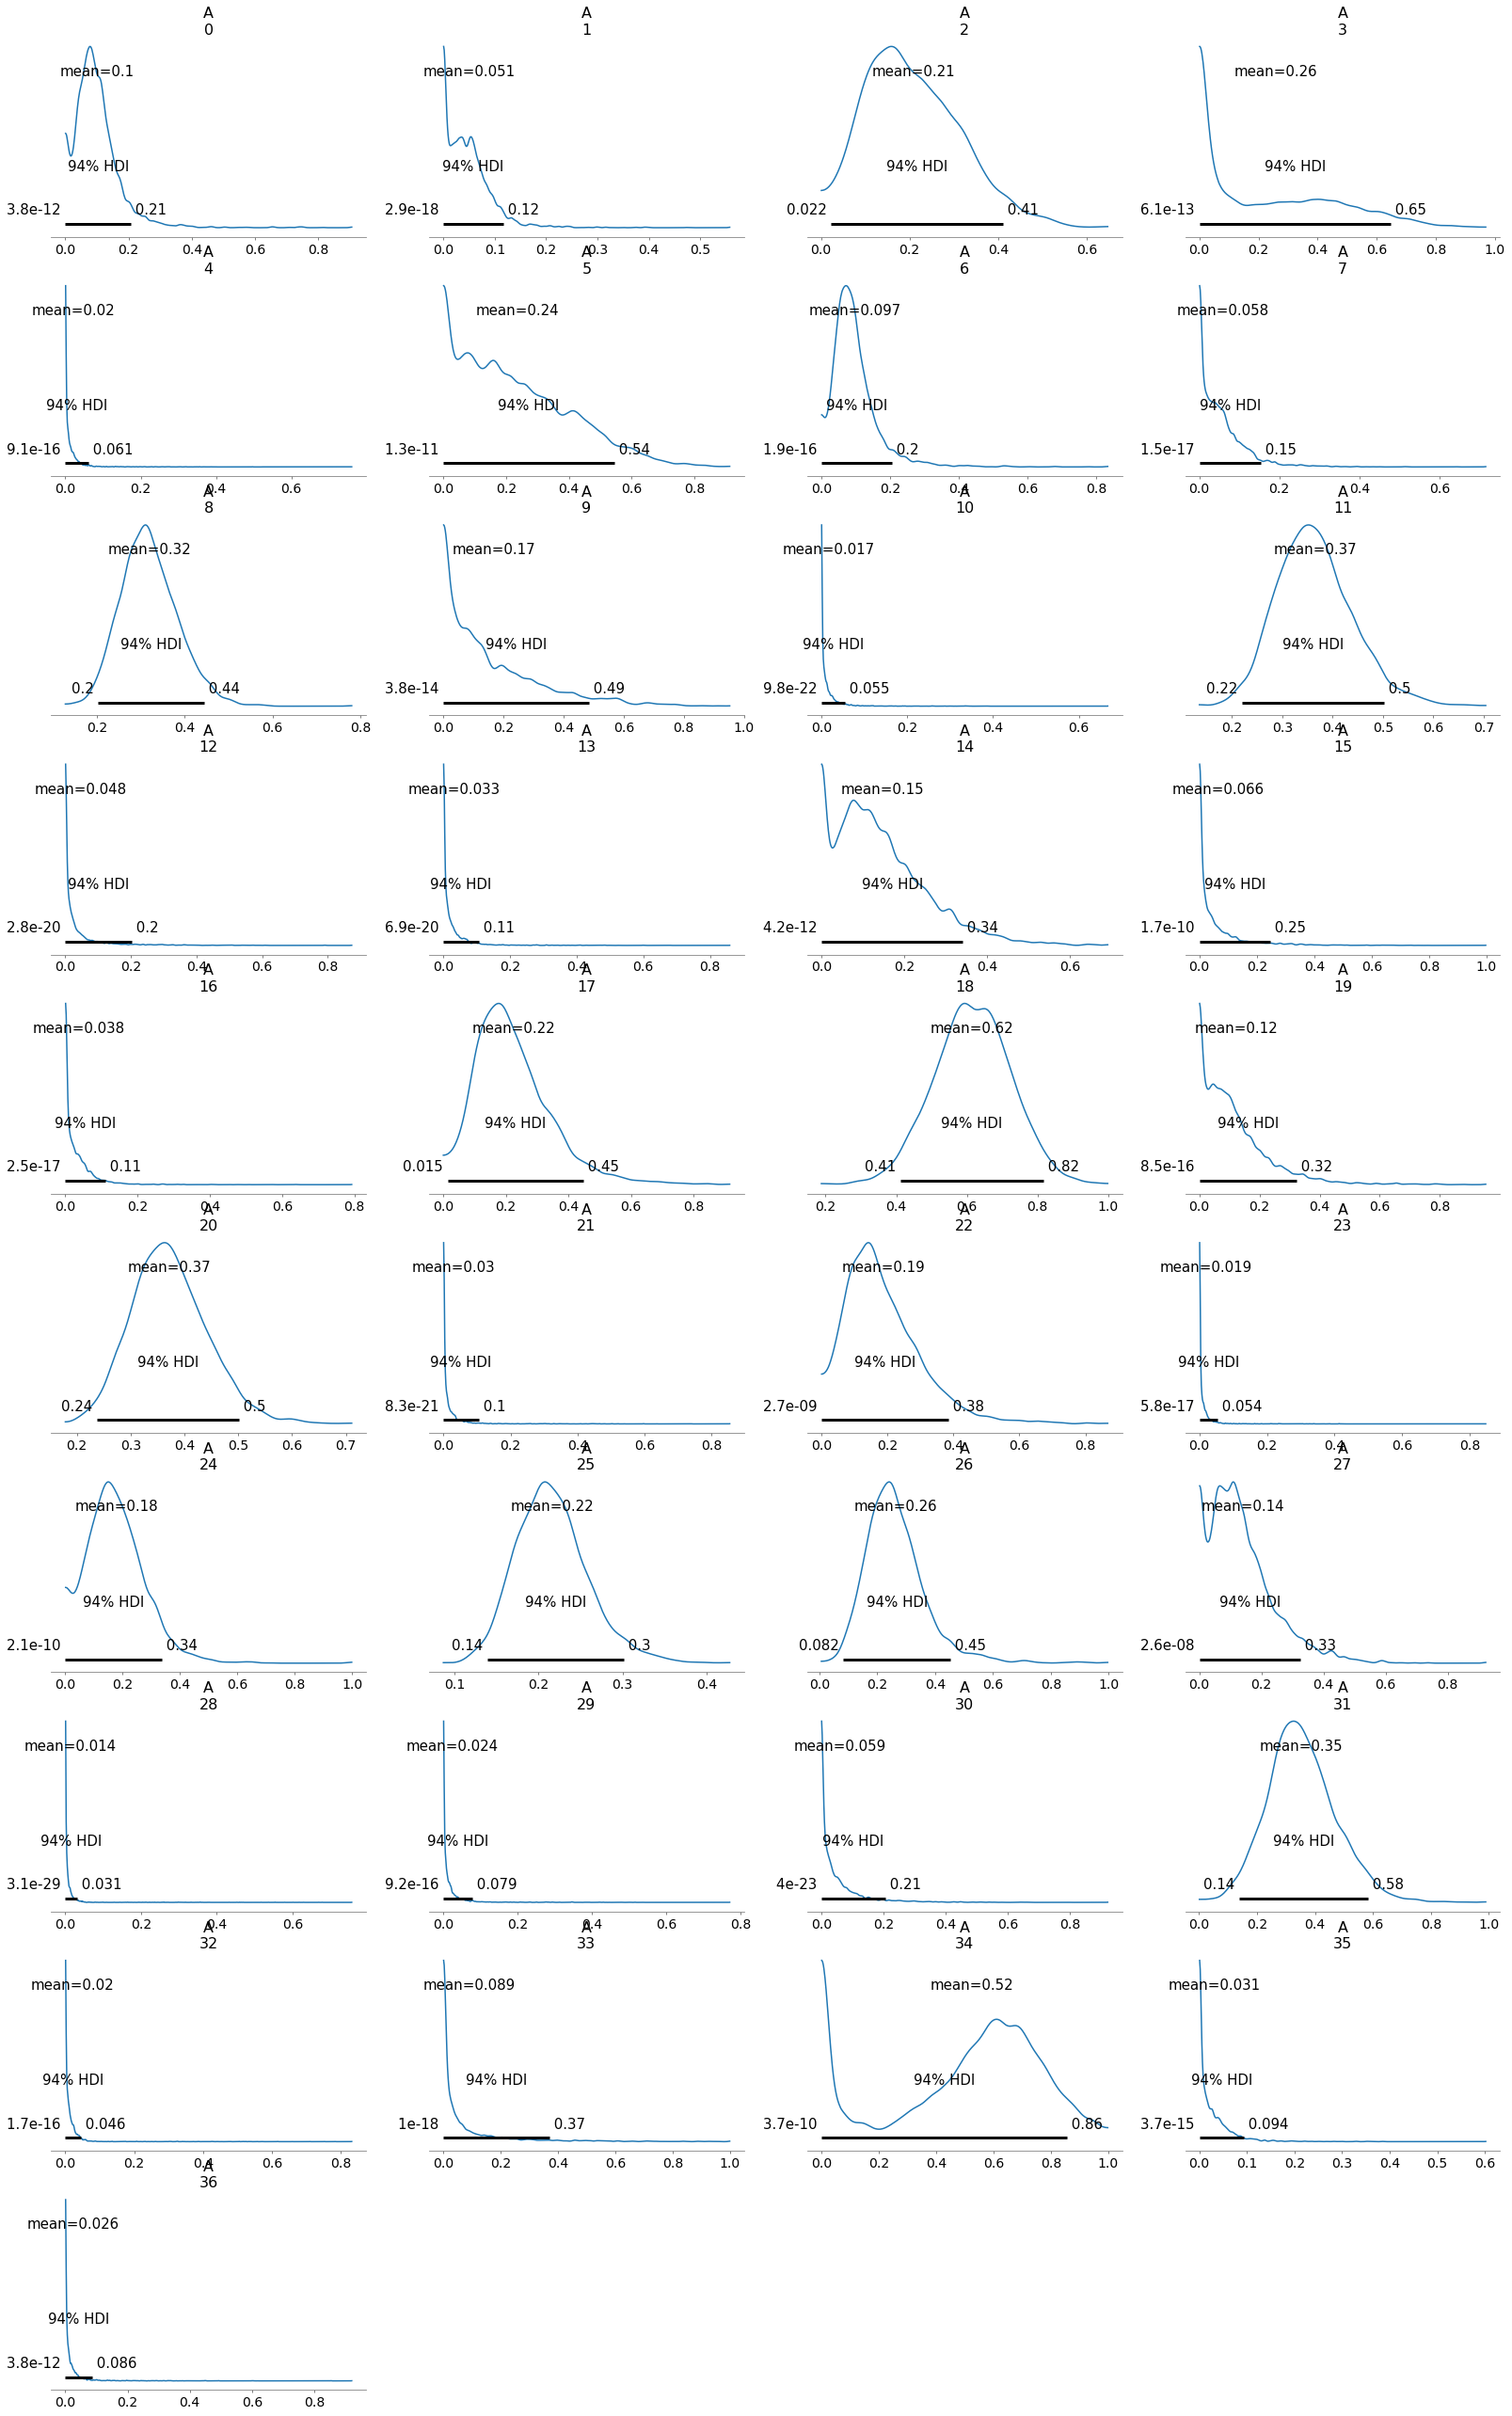

In [97]:
az.plot_posterior(model, var_names=['A'])

In [116]:
alpha = 0.1
Vcsp = [5]
df = db1[db1['sub']=='10'].reset_index()
r = 0

for i in range(1,len(df)):
    if df.rectOri[i] == df.CSp[i]:
        
        PE = r - Vcsp[-1]
        Vcsp.append(Vcsp[-1] + alpha * PE)
        
        if df.rectValue[i] == 6:
            r = 9
        else:
            r = 0

In [131]:
Vacc = df[df['rectOri']==df.CSp]['rating']

figg = pd.DataFrame(Vacc, Vcsp)

In [132]:
Vacc = Vacc.reset_index()
Vacc['pred'] = Vcsp
Vacc

,index,rating,pred
0,0,3,5.000000
1,2,5,4.500000
2,4,4,4.950000
3,5,2,4.455000
4,7,7,4.909500
5,8,6,4.418550
6,10,6,3.976695
7,11,4,3.579026
8,14,0,3.221123
9,15,4,2.899011


<AxesSubplot:>

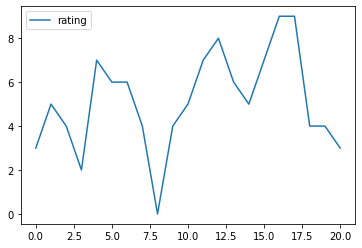

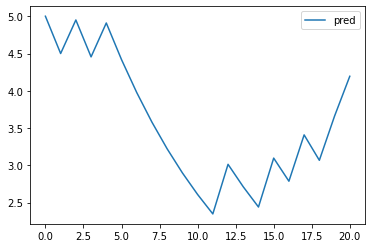

In [138]:
Vacc.plot(y='rating')
Vacc.plot(y='pred')